# Olympic Running Analysis

The purpose of this project is to answer the question, "how competitive are the running events at the olympics and how have they changed over time?". To answer this question, we will be collecting the top three winning times at the olympic games for a subset of the running events. We will focus on individual running sports: 100, 200, 400, 800, 1500, 5000, 10000 meter races and the marathon. My hypothesis is that the winning times will decrease over time, implying that runners are required to be very fit and fast to participate and win the olympic games.

## Source

We will use the [Olympedia](http://www.olympedia.org/) website to scrape the relevant events for this analysis. This website contains results for all events in the Olympic games from 1896 to 2016.

We begin our analysis by importing the necessary packages.

In [201]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

# for scraping
from bs4 import BeautifulSoup as Soup
from urllib.request import urlopen

# colors that we will use later
FIRST = '#2471A3' # green
SECOND = '#F1C40F' # light blue
THIRD = '#A93226' # orange
colors = [FIRST, SECOND, THIRD]

In [202]:
# define the current working directory
CWD = os.getcwd()
DATA = os.path.join(CWD, 'data')
# make data folder if it is not there
if not os.path.isdir(DATA):
    os.mkdir(DATA)
    
# save url that we'll use to find the data
URL = 'http://www.olympedia.org'
TRACK_URL = URL + '/sports/ATH'

## Data Collection

Below is the custom class that I built for this project. We will navigate the [Olympedia](http://www.olympedia.org/) website in three steps.

- 1) We scrape the event names for the running events from the first website. When scraping the event names, we will also save the url that leads to the years that the event was held in.


- 2) For each event, we scrape the years that the event took place in. We will also save the url that leads to the data for each year we scrape.


- 3) For each year, we will check that the relevant headers are included and then we save the top three scores of each event into a pandas dataframe.

In [203]:
# build a class for this project
class Scraper():
    
    def build_soup(self, url):
        """
        create a soup object
        """
        self.soup = Soup(urlopen(url))
        
    def scrape_events(self):
        """
        scrape the events that are included in the website
        save it as a dictionary with men's and women's sections
        'event_name' : {'sex': 'link'}
        """
        self.event_dict = {}
        running_events = ['100 metres', 
                          '200 metres',
                          '400 metres', 
                          '800 metres',
                          '1,500 metres',
                          '5,000 metres', 
                          '10,000 metres',
                          'Marathon']
        
        # save the table that contains the events
        table = self.soup.find('table', {'class': 'table table-striped sortable'})
        # look at each row in the table
        for tr in table.find_all('tr'):
            # the information is in each td element
            td_list = tr.find_all('td')
            # the name of the event is the first td
            # the gender is in the second td
            if (td_list[1].text not in ['Men', 'Women']) or (td_list[0].text not in running_events):
                pass
            else:
                # add event to the dict if it is the first encounter
                if td_list[0].text not in self.event_dict.keys():
                    self.event_dict[td_list[0].text] = {}
                    
                self.event_dict[td_list[0].text][td_list[1].text] = td_list[0].a.get('href')
    
    def scrape_years_per_event(self):
        """
        for each event and each gender, collect all the years that the event took place
        and the url that leads to the data. Save it in the following format
        
        'event_name' : {'men' : {'year' : 'url'},
                        'women' : {'year' : 'url'}
        """
        self.event_years_dict = {}
        # loop through each event
        for event in self.event_dict.keys():
            # loop through each gender in each event
            for gender in self.event_dict[event].keys():
                # build a page soup for each event/gender combo
                self.build_soup(URL + self.event_dict[event][gender])
                # grab the table that contains the years and urls
                table = self.soup.find('table', {'class': 'table table-striped'})
                for tr in table.find_all('tr'):
                    td_list = tr.find_all('td')
                    # make sure the list has something
                    if len(td_list) != 0:
                        # year is the first element
                        year = td_list[0].text
                        # url is the second element
                        url = td_list[1].a.get('href')
                        # add event to the dict if it is the first encounter
                        if event not in self.event_years_dict.keys():
                            self.event_years_dict[event] = {}
                        # add gender to the dict if it is the first encounter
                        if gender not in self.event_years_dict[event].keys():
                            self.event_years_dict[event][gender] = {}
                        # save the url to the dict
                        self.event_years_dict[event][gender][year] = url
    
    def good_header(self):
        """
        Only scrape the data if the website header contains the information I am looking for.
        Will return True if all of the headers are present, False otherwise.
        I am looking for Position, Athlete, NOC (Country), and Final (time)
        """
        header_list = ['Pos', 'Athlete', 'NOC', 'Final']
        bool_list = [False]*4
        # grab the table containing the data
        table = self.soup.find('table', {'class' : 'table table-striped'})
        # the header is in the first tr
        tr = table.find('tr')
        # the header names are in th elements
        th_list = tr.find_all('th')
        th_text = [th.text for th in th_list]
        
        # now check that all desired headers are in the header we are looking at
        for ind, header in enumerate(header_list):
            if header in th_text:
                bool_list[ind] = True
        
        return all(bool_list)
    
    def find_index(self, header_name):
        """
        Find where the header_name is in the page's header, return the index
        """
        table = self.soup.find('table', {'class' : 'table table-striped'})
        # header is in the first tr
        tr = table.find('tr')
        # header names are in th elements
        th_list = tr.find_all('th')
        for ind, th in enumerate(th_list):
            if header_name in th:
                return ind
    
    def scrape_data(self):
        """
        Go through each event/gender/year in the event_years_dict and scrape the top 3 winning times.
        If the scraping is successful, it will be added to a pandas dataframe.
        The dataframe will contain Event, Gender, Year, Athlete, Position, Country, and Time as
        column names
        """
        index = 0
        self.df = pd.DataFrame(columns = ['Event',
                                          'Gender',
                                          'Year',
                                          'Position',
                                          'Athlete',
                                          'Country',
                                          'Time'])
        
        # start looping through the dictionary
        for event in self.event_years_dict.keys():
            # loop through genders
            for gender in self.event_years_dict[event].keys():
                # loop through years
                for year in self.event_years_dict[event][gender].keys():
                    # build a soup object for this year's event
                    self.build_soup(URL + self.event_years_dict[event][gender][year])
                    # check to see that the header contains the information we want
                    if self.good_header():
                        # grab the top three scores
                        # start with the table
                        table = self.soup.find('table', {'class' : 'table table-striped'})
                        # the relevant data is in each tr element
                        for ind, tr in enumerate(table.find_all('tr')):
                            # we only want the top three scores
                            if ind in range(1,4):
                                td_list = tr.find_all('td')
                                position = td_list[self.find_index('Pos')].text
                                athlete = td_list[self.find_index('Athlete')].text
                                country = td_list[self.find_index('NOC')].a.text
                                final_time = td_list[self.find_index('Final')].text
                                
                                tmp_dict = {'Event': event,
                                            'Gender' : gender,
                                            'Year' : year,
                                            'Position' : position,
                                            'Athlete' : athlete,
                                            'Country' : country,
                                            'Time' : final_time}
                                # add the data to the dataframe
                                self.df.loc[index] = pd.Series(tmp_dict)
                                index += 1

The first step is to create an instance of the custom class. Then we build a soup object of the main url that contains the relevant running events.

In [204]:
# create an instance of my scraper class
scraper = Scraper()
# create soup object for the main site
scraper.build_soup(TRACK_URL)

Next we run the '.scrape_events()' method that will collect the events that we are interested in. Afterwards we print the '.event_dict' attribute to view the events that were scraped.

In [205]:
# scrape the event names, genders and urls on the main site
scraper.scrape_events()
# view the scraped items
scraper.event_dict

{'100 metres': {'Men': '/event_names/40', 'Women': '/event_names/95'},
 '200 metres': {'Men': '/event_names/41', 'Women': '/event_names/96'},
 '400 metres': {'Men': '/event_names/42', 'Women': '/event_names/97'},
 '800 metres': {'Men': '/event_names/43', 'Women': '/event_names/98'},
 '1,500 metres': {'Men': '/event_names/44', 'Women': '/event_names/99'},
 '5,000 metres': {'Men': '/event_names/45', 'Women': '/event_names/101'},
 '10,000 metres': {'Men': '/event_names/47', 'Women': '/event_names/102'},
 'Marathon': {'Men': '/event_names/48', 'Women': '/event_names/103'}}

Next we run the '.scrape_years_per_event()' method that will collect the years in each event. Afterwards we print the '.event_years_dict' attribute to view the years and urls that were saved.

In [206]:
# scrape the years in each event for each gender and save url
scraper.scrape_years_per_event()
# view scraped items
scraper.event_years_dict

{'100 metres': {'Men': {'1896': '/results/56000',
   '1900': '/results/56034',
   '1904': '/results/56117',
   '1906': '/results/56173',
   '1908': '/results/56265',
   '1912': '/results/56530',
   '1920': '/results/57032',
   '1924': '/results/57285',
   '1928': '/results/57590',
   '1932': '/results/57919',
   '1936': '/results/58143',
   '1948': '/results/58482',
   '1952': '/results/58826',
   '1956': '/results/59241',
   '1960': '/results/59618',
   '1964': '/results/60072',
   '1968': '/results/60512',
   '1972': '/results/61005',
   '1976': '/results/61607',
   '1980': '/results/62161',
   '1984': '/results/62625',
   '1988': '/results/63261',
   '1992': '/results/63952',
   '1996': '/results/64629',
   '2000': '/results/65310',
   '2004': '/results/66009',
   '2008': '/results/257142',
   '2012': '/results/302122',
   '2016': '/results/358560',
   '2020': '/results/19000360'},
  'Women': {'1928': '/results/57875',
   '1932': '/results/58111',
   '1936': '/results/58430',
   '19

Finally, we go through each year and save the top three scores for each event.

In [207]:
# get the top three scores for all events in the dict
scraper.scrape_data()

In [208]:
# save the df before we clean it
# so that we don't have to run the above since it takes so long
scraper.df.to_csv(os.path.join(DATA, 'dirty_data.csv'), index = False)

## Data Exploration

Let's take a look at the data that we just collected before we clean it. Below we will see the dataframe's head, the events that were scraped, the genders we saved, the positions of each athlete, the years that were scraped, and the number of events that we scraped.

In [209]:
# look at the first 5 rows
scraper.df.head()

,Event,Gender,Year,Position,Athlete,Country,Time
0,100 metres,Men,1896,1,Tom Burke,USA,12 (1)
1,100 metres,Men,1896,2,Fritz Hofmann,GER,at 2 metres (2)
2,100 metres,Men,1896,=3,Alajos Szokoly,HUN,at 4 metres (=3)
3,100 metres,Men,1900,1,Frank Jarvis,USA,11.0 (1)
4,100 metres,Men,1900,2,Walter Tewksbury,USA,at 2 feet (2)


In [210]:
# make sure all events are in the dataframe
scraper.df['Event'].unique()
# looks like we lost the marathon

array(['100 metres', '200 metres', '400 metres', '800 metres',
       '1,500 metres', '5,000 metres', '10,000 metres'], dtype=object)

In [211]:
# only men and women
scraper.df['Gender'].unique()

array(['Men', 'Women'], dtype=object)

In [212]:
# position should only be 1,2,3
scraper.df['Position'].unique()
# fix the =3 and =2

array(['1', '2', '=3', '3', '=2'], dtype=object)

In [213]:
# which years are included?
scraper.df['Year'].unique()

array(['1896', '1900', '1904', '1906', '1908', '1912', '1920', '1924',
       '1928', '1932', '1936', '1948', '1952', '1956', '1960', '1964',
       '1968', '1972', '1976', '1980', '1984', '1988', '1992', '1996',
       '2000', '2004', '2008', '2012', '2016'], dtype=object)

In [214]:
# how many events did we scrape?
scraper.df.shape[0]

786

## Data Cleaning

I would like to clean the positions in the dataframe. Some of the positions include an equal sign. This means that the position was a tie. I will first remove the equal signs from the dataframe.

In [215]:
# fixing the position column so it only includes 1,2,3 as strings
scraper.df.loc[scraper.df['Position'] == '=3', 'Position'] = '3'
scraper.df.loc[scraper.df['Position'] == '=2', 'Position'] = '2'
print(scraper.df['Position'].unique())
scraper.df.head()

['1' '2' '3']


,Event,Gender,Year,Position,Athlete,Country,Time
0,100 metres,Men,1896,1,Tom Burke,USA,12 (1)
1,100 metres,Men,1896,2,Fritz Hofmann,GER,at 2 metres (2)
2,100 metres,Men,1896,3,Alajos Szokoly,HUN,at 4 metres (=3)
3,100 metres,Men,1900,1,Frank Jarvis,USA,11.0 (1)
4,100 metres,Men,1900,2,Walter Tewksbury,USA,at 2 feet (2)


Next we will replace the times that have any distance measurements with NA. The earlier olympics only recorded the time of the winner and the position of the remaining athletes with respect to the winner. This isn't helpful in this analysis, so we will replace them with NA.

In [216]:
# fixing the weird times
scraper.df['Time'].replace(regex = 'at', value = np.nan, inplace = True)
scraper.df.head()

,Event,Gender,Year,Position,Athlete,Country,Time
0,100 metres,Men,1896,1,Tom Burke,USA,12 (1)
1,100 metres,Men,1896,2,Fritz Hofmann,GER,NaN
2,100 metres,Men,1896,3,Alajos Szokoly,HUN,NaN
3,100 metres,Men,1900,1,Frank Jarvis,USA,11.0 (1)
4,100 metres,Men,1900,2,Walter Tewksbury,USA,NaN


Let's see what kind of times are included in this dataset. We need to format it so that it is easy to compare the times between each event.

In [217]:
# look at all of the possible times
scraper.df['Time'].values

array(['12 (1)', nan, nan, '11.0 (1)', nan, nan, '11.0 (1)', '11.2 (2)',
       '11.2 (3)', '11.2 (1)', nan, nan, '10.8 (1)', nan,
       '11.0est / close behind (3)', '10.8 (1)', '10.9est (2)',
       '10.9est (3)', '10.8 (1)', nan, '10.9est / chest behind (3)',
       '10.6 (1)', '10.7 (2)', '10.8 (3)', '10.8 (1)', '10.9 (2)',
       '10.9 (3)', '10.3 (1)', '10.3 (2)', '10.4 (3)', '10.3w (1)',
       '10.4w (2)', '10.5w (3)', '10.3 (1)', '10.4 (2)', '10.6 (3)',
       '10.4 (1)', '10.4 (2)', '10.4 (3)', '10.5 (1)', '10.5 (2)',
       '10.6 (3)', '10.2 (1)', '10.2 (2)', '10.3 (3)', '10.0 (1)',
       '10.2 (2)', '10.2 (3)', '9.9 (1)', '10.0 (2)', '10.0 (3)',
       '10.14 (1)', '10.24 (2)', '10.33 (3)', '10.06 (1)', '10.08 (2)',
       '10.14 (3)', '10.25 (1)', '10.25 (2)', '10.39 (3)', '9.99 (1)',
       '10.19 (2)', '10.22 (3)', '9.92 (1)', '9.97 (2)', '9.99 (3)',
       '9.96 (1)', '10.02 (2)', '10.04 (3)', '9.84 (1)', '9.89 (2)',
       '9.90 (3)', '9.87 (1)', '9.99 (2)', '10.04 (

There are a few things we need to fix.

- 1) Some of the times have "est", we will delete that.
- 2) All of the times have a (1), (2), or (3) to determine the position of the time. This is not needed since we are saving the position in another column.
- 3) Some of the times have a "w" or "e" at the end of it. We will remove that "w" or "e".

In [218]:
def clean_time(time):
    # look for the beginning bracket or 'est' or blank space
    if re.search('\(.*|est.*|\s|.*w.*|e.*', time):
        
        # find the position where the pattern begins
        pos = re.search('\(.*|est.*|\s|w.*|e.*', time).start()
        
        return time[ : pos]
    else:
        # the time is good
        return time

In [219]:
scraper.df['Time'] = scraper.df['Time'].astype('str')
scraper.df['Time'] = scraper.df['Time'].apply(clean_time)

In [220]:
scraper.df['Time'].values

array(['12', 'nan', 'nan', '11.0', 'nan', 'nan', '11.0', '11.2', '11.2',
       '11.2', 'nan', 'nan', '10.8', 'nan', '11.0', '10.8', '10.9',
       '10.9', '10.8', 'nan', '10.9', '10.6', '10.7', '10.8', '10.8',
       '10.9', '10.9', '10.3', '10.3', '10.4', '10.3', '10.4', '10.5',
       '10.3', '10.4', '10.6', '10.4', '10.4', '10.4', '10.5', '10.5',
       '10.6', '10.2', '10.2', '10.3', '10.0', '10.2', '10.2', '9.9',
       '10.0', '10.0', '10.14', '10.24', '10.33', '10.06', '10.08',
       '10.14', '10.25', '10.25', '10.39', '9.99', '10.19', '10.22',
       '9.92', '9.97', '9.99', '9.96', '10.02', '10.04', '9.84', '9.89',
       '9.90', '9.87', '9.99', '10.04', '9.85', '9.86', '9.87', '9.69',
       '9.89', '9.91', '9.63', '9.75', '9.79', '9.81', '9.89', '9.91',
       '12.2', '12.3', '12.3', '11.9', '11.9', '12.0', '11.5', '11.7',
       '11.9', '11.9', '12.2', '12.2', '11.5', '11.8', '11.9', '11.5',
       '11.7', '11.7', '11.0', '11.3', '11.3', '11.4', '11.6', '11.6',
       '11.

In [221]:
# there is a leftover "-" in the values. I will replace it with NA
scraper.df['Time'].replace(to_replace = '–', value = np.nan, inplace = True)
scraper.df['Time'].values

array(['12', 'nan', 'nan', '11.0', 'nan', 'nan', '11.0', '11.2', '11.2',
       '11.2', 'nan', 'nan', '10.8', 'nan', '11.0', '10.8', '10.9',
       '10.9', '10.8', 'nan', '10.9', '10.6', '10.7', '10.8', '10.8',
       '10.9', '10.9', '10.3', '10.3', '10.4', '10.3', '10.4', '10.5',
       '10.3', '10.4', '10.6', '10.4', '10.4', '10.4', '10.5', '10.5',
       '10.6', '10.2', '10.2', '10.3', '10.0', '10.2', '10.2', '9.9',
       '10.0', '10.0', '10.14', '10.24', '10.33', '10.06', '10.08',
       '10.14', '10.25', '10.25', '10.39', '9.99', '10.19', '10.22',
       '9.92', '9.97', '9.99', '9.96', '10.02', '10.04', '9.84', '9.89',
       '9.90', '9.87', '9.99', '10.04', '9.85', '9.86', '9.87', '9.69',
       '9.89', '9.91', '9.63', '9.75', '9.79', '9.81', '9.89', '9.91',
       '12.2', '12.3', '12.3', '11.9', '11.9', '12.0', '11.5', '11.7',
       '11.9', '11.9', '12.2', '12.2', '11.5', '11.8', '11.9', '11.5',
       '11.7', '11.7', '11.0', '11.3', '11.3', '11.4', '11.6', '11.6',
       '11.

Now we format the time so that it is a float object and only contains seconds. We will save this into a new column.

In [222]:
def to_seconds(time):
    """
    return the time as seconds
    """
    if re.search('.*:', time):
        
        # find where the colon is
        pos = re.search(':', time).start()
        minutes = int(time[ : pos])
        min_to_seconds = minutes*60
        
        # return the total seconds
        return min_to_seconds + float(time[pos + 1: ])
    else:
        return float(time)

In [223]:
scraper.df['Time'] = scraper.df['Time'].astype('str')
scraper.df['Time(seconds)'] = scraper.df['Time'].apply(to_seconds)
scraper.df['Time(seconds)'].values

array([  12.  ,     nan,     nan,   11.  ,     nan,     nan,   11.  ,
         11.2 ,   11.2 ,   11.2 ,     nan,     nan,   10.8 ,     nan,
         11.  ,   10.8 ,   10.9 ,   10.9 ,   10.8 ,     nan,   10.9 ,
         10.6 ,   10.7 ,   10.8 ,   10.8 ,   10.9 ,   10.9 ,   10.3 ,
         10.3 ,   10.4 ,   10.3 ,   10.4 ,   10.5 ,   10.3 ,   10.4 ,
         10.6 ,   10.4 ,   10.4 ,   10.4 ,   10.5 ,   10.5 ,   10.6 ,
         10.2 ,   10.2 ,   10.3 ,   10.  ,   10.2 ,   10.2 ,    9.9 ,
         10.  ,   10.  ,   10.14,   10.24,   10.33,   10.06,   10.08,
         10.14,   10.25,   10.25,   10.39,    9.99,   10.19,   10.22,
          9.92,    9.97,    9.99,    9.96,   10.02,   10.04,    9.84,
          9.89,    9.9 ,    9.87,    9.99,   10.04,    9.85,    9.86,
          9.87,    9.69,    9.89,    9.91,    9.63,    9.75,    9.79,
          9.81,    9.89,    9.91,   12.2 ,   12.3 ,   12.3 ,   11.9 ,
         11.9 ,   12.  ,   11.5 ,   11.7 ,   11.9 ,   11.9 ,   12.2 ,
         12.2 ,   11

In [224]:
scraper.df.tail()

,Event,Gender,Year,Position,Athlete,Country,Time,Time(seconds)
781,"10,000 metres",Women,1996,2,Wang Junxia,CHN,31:02.58,1862.58
782,"10,000 metres",Women,1996,3,Gete Wami,ETH,31:06.65,1866.65
783,"10,000 metres",Women,2000,1,Derartu Tulu,ETH,30:17.49,1817.49
784,"10,000 metres",Women,2000,2,Gete Wami,ETH,30:22.48,1822.48
785,"10,000 metres",Women,2000,3,Fernanda Ribeiro,POR,30:22.88,1822.88


## Exploring the Winning Times over the Years

We will plot all of the men's events one by one, then discuss the results. After we will do the same for the women's events.

In [225]:
def plot_event(df, event, gender):
    """
    Make a line plot over time for a given event and gender.
    """
    
    sns.set_palette(sns.color_palette(colors))
    # set up the figure
    fig, axs = plt.subplots(1,1, figsize = (8,5), dpi = 100)
    
    # filter the df
    filtered_df = df[df['Event'] == event]
    filtered_df = filtered_df[filtered_df['Gender'] == gender]
    filtered_df['Year'] = filtered_df['Year'].astype('int64')
    
    # plot with seaborn
    g = sns.lineplot(x = 'Year',
                    y = 'Time(seconds)',
                    data = filtered_df,
                    ax = axs,
                    hue = 'Position',
                    legend = False)
    
    
    g = sns.scatterplot(x = 'Year',
                        y = 'Time(seconds)',
                        data = filtered_df,
                        ax = axs,
                        hue = 'Position',
                        edgecolor = 'k',
                        linewidth = 0.75)

    # finishing touches
    g.set(title = 'Winning {} times over the years for {} race'.format(gender, event))
    g.set(ylim = (0.97*filtered_df['Time(seconds)'].min(), 1.02*filtered_df['Time(seconds)'].max()))
    plt.tight_layout()
    plt.show()

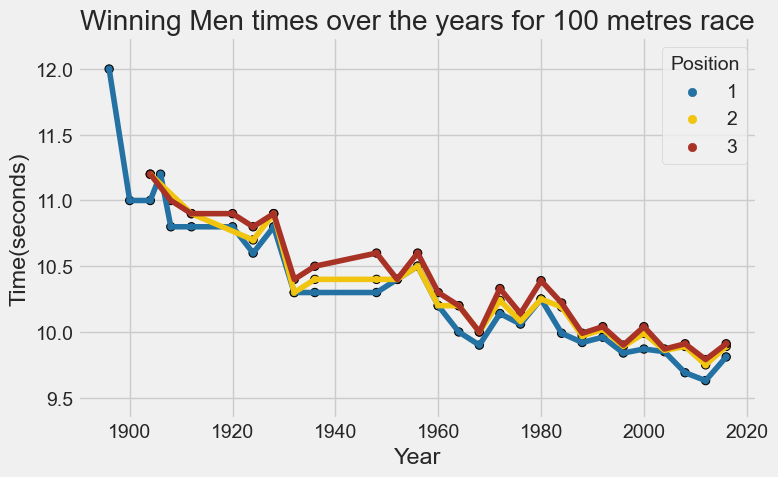

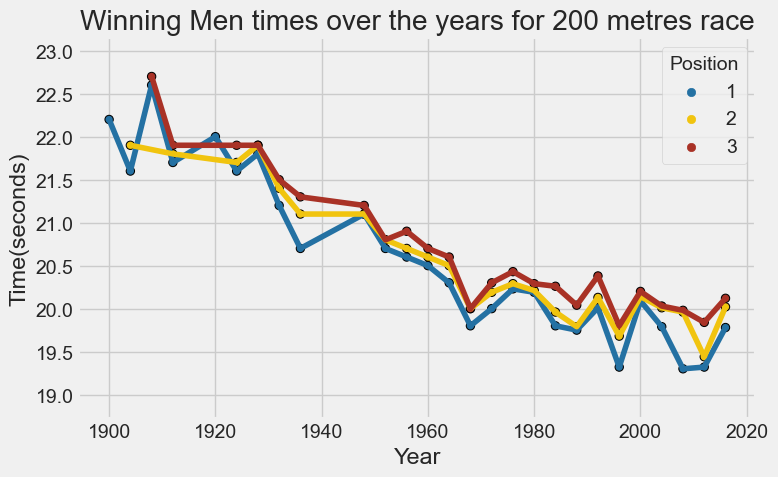

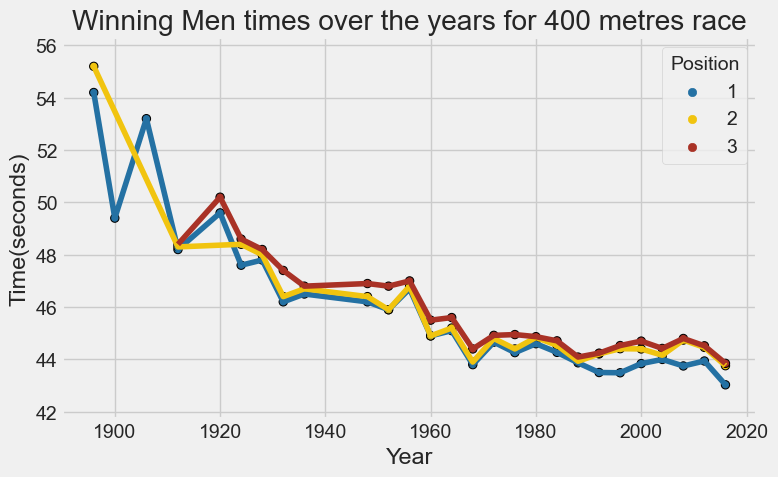

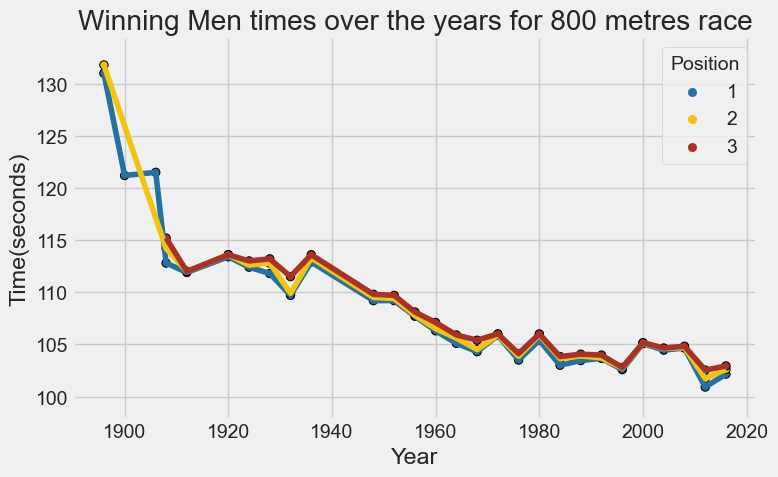

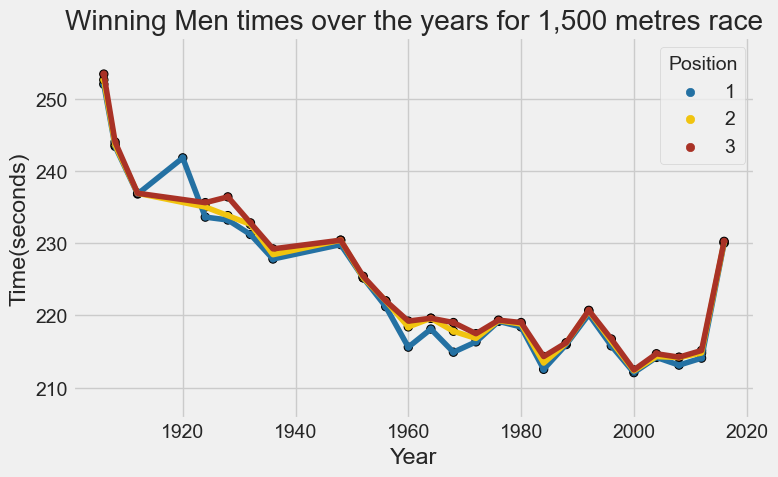

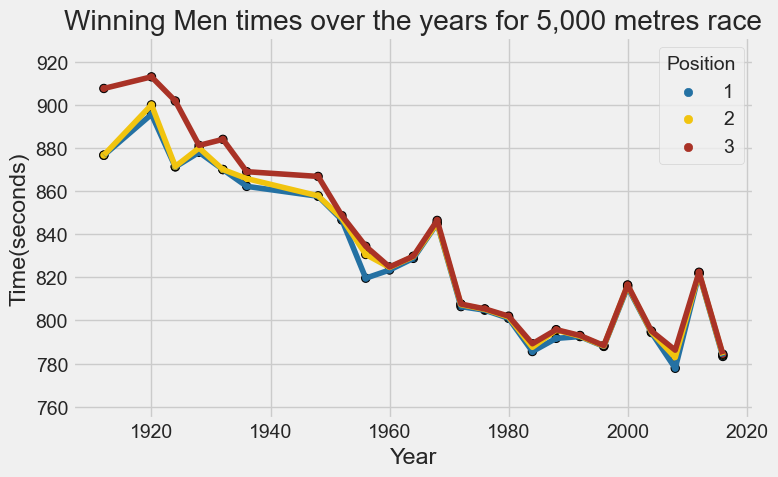

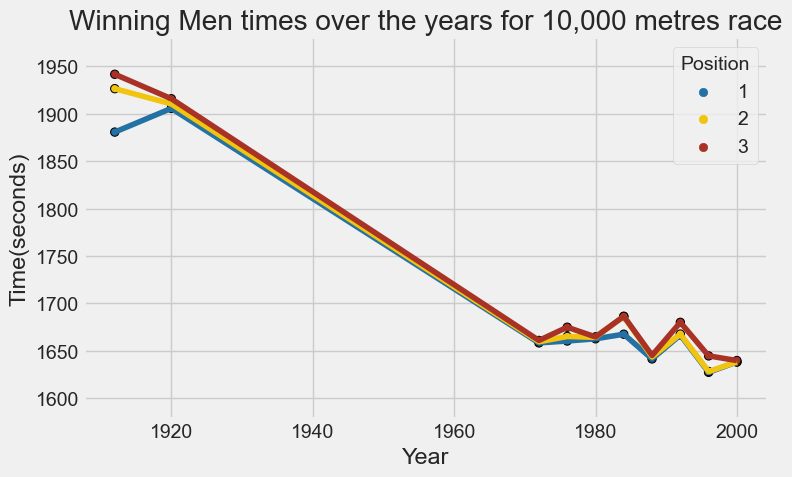

In [226]:
for event in scraper.df['Event'].unique():
    plot_event(scraper.df, event, 'Men')

## Results for Men
If we look at the plots above, we can see a trend over the years where the winning times are slightly faster than the previous olympic games. This downward trend is most evident in the 100 and 200 meter races. We also see that the times for all three positions are relatively close to each other, implying that these olympic races are close calls and that it is a very competitive environment to be in.

Now let's look at the plots for women.

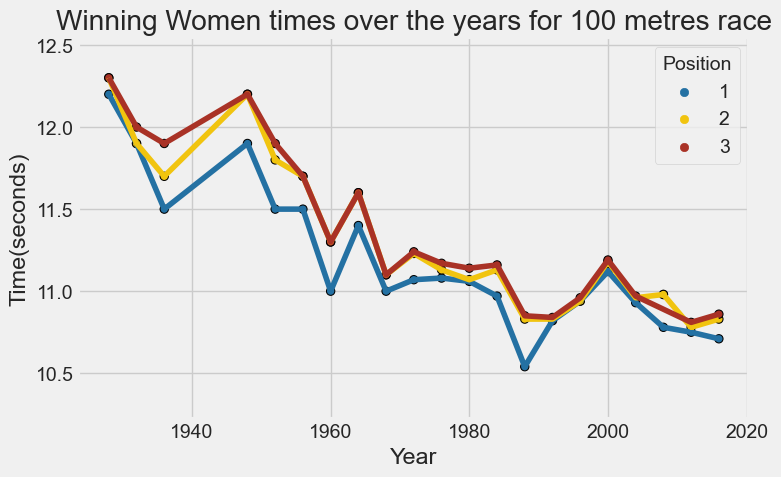

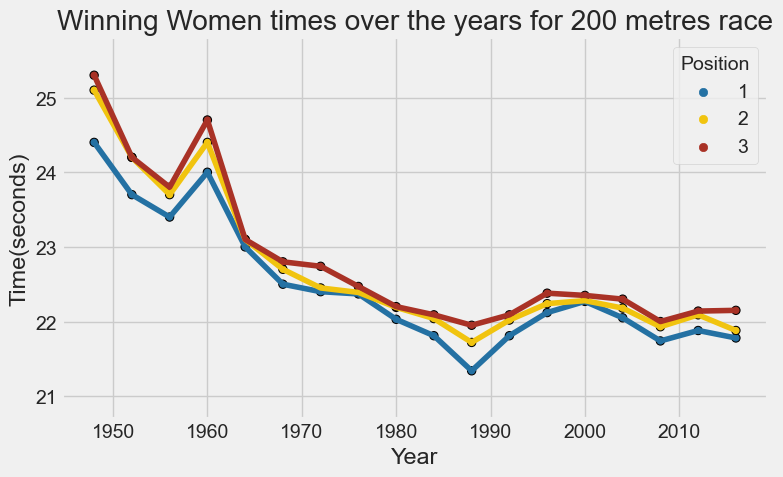

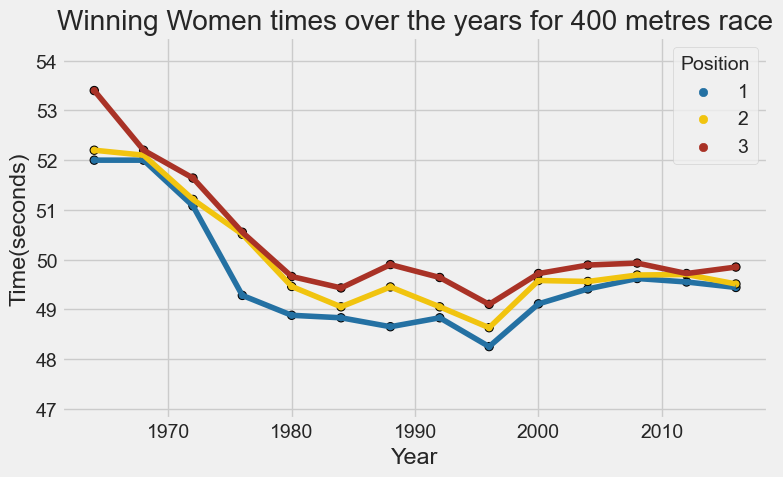

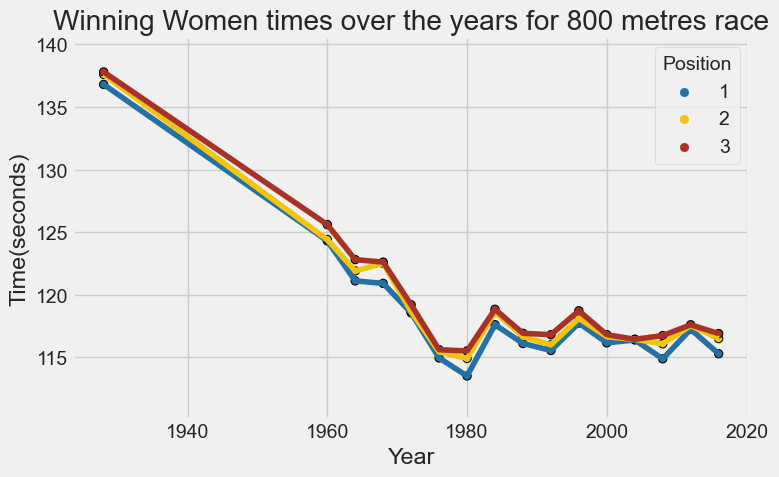

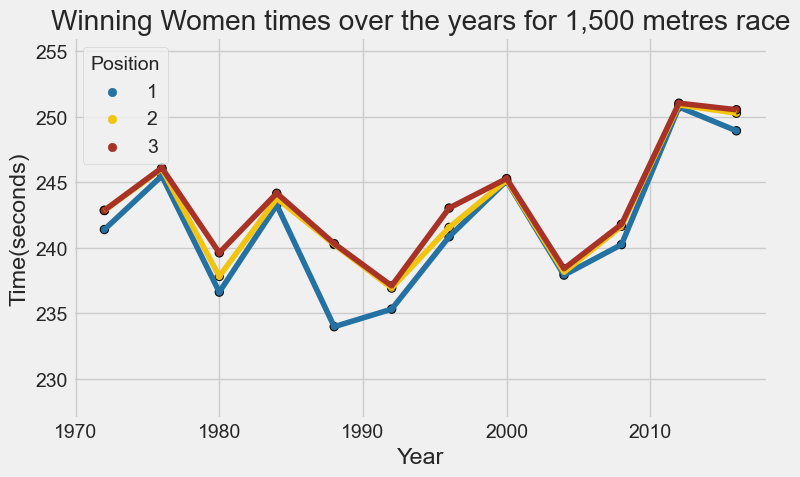

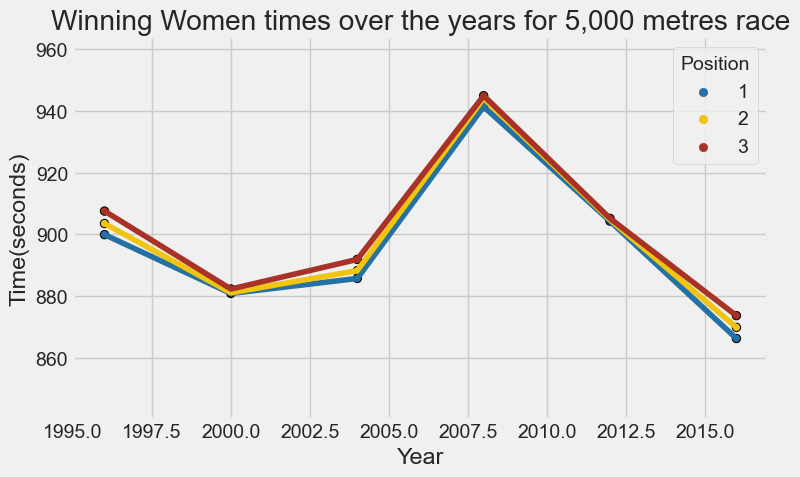

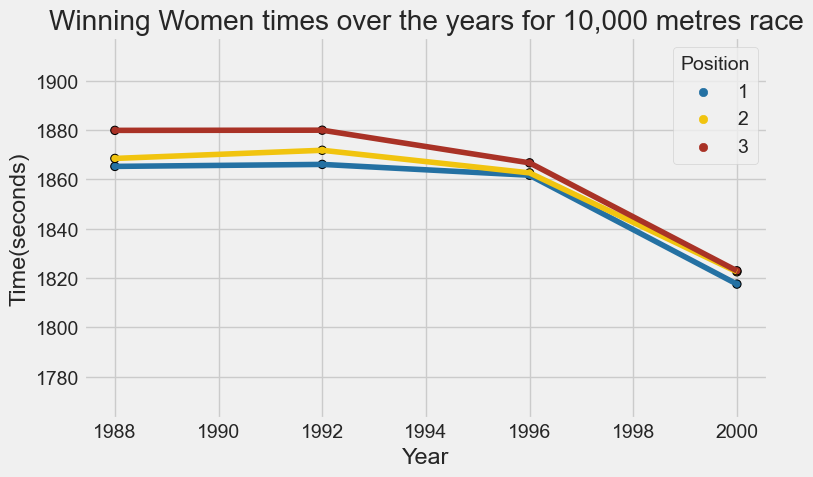

In [227]:
for event in scraper.df['Event'].unique():
    plot_event(scraper.df, event, 'Women')

## Results for Women

Similarly to the men's plots, we see a downward trend in the winning times for the female olympians. We also see this trend very clearly in the 100 and 200 meter races. There is a strange increase in time for the Women's 5,000 meter race in 2018 where every position did worse than the previous olympics, but after that year we still see the downward trend.

## Some More Exploring

Let's now answer a few interesting questions one at a time.

**Which countries have won gold the most?**

In [228]:
first_place = scraper.df[scraper.df['Position'] == '1']['Country'].value_counts()
print('The top three countries with the most Gold Medals for both genders.')
print('===================================================================')
print(first_place.iloc[:3])

The top three countries with the most Gold Medals for both genders.
USA    83
GBR    20
JAM    15
Name: Country, dtype: int64


Looks like the United States takes the lead with 83 Gold medals, followed by the United Kingdom with 20, then Jamaica with 15.

**Which athletes have won the most gold medals?**

In [229]:
top_athletes = scraper.df[scraper.df['Position'] == '1']['Athlete'].value_counts()
print('The top three athletes with the most Gold Medals for both genders.')
print('==================================================================')
print(top_athletes.iloc[:3])

The top three athletes with the most Gold Medals for both genders.
Usain Bolt        6
Lasse Virén       4
Betty Cuthbert    3
Name: Athlete, dtype: int64


Looks like we have a familiar name! Usain Bolt has made a name for himself recently and the data shows that he has won the most olympic gold medals for running events ever.

One of the most entertaining races to watch is the 100 meter dash. 

**Let's see what is the fastest 100 meter dash in this dataset.**

In [230]:
sprint_100 = scraper.df[scraper.df['Event'] == '100 metres'][['Gender','Time(seconds)']]
sprint_100.groupby(by = 'Gender').min()

,Time(seconds)
Gender,
Men,9.63
Women,10.54


Let's give these numbers some context by showing what the average time for this race is.

In [231]:
sprint_100.groupby(by = 'Gender').mean()

,Time(seconds)
Gender,
Men,10.319747
Women,11.275079


We can see that the fastest man and woman in the 100 meter race were faster than the average time for their respective genders by about 0.7 seconds! That really shows how competitive these events really are.

In [232]:
# save the final cleaned dataset locally
scraper.df.to_csv(os.path.join(DATA, 'final_data.csv'), index = False)

## Conclusion

The purpose of this project was to determine how competitive the olympic running events are and to see how much faster the athletes are each time the olympics take place. After aquiring relevant data, we can see that the times top three winnning times for each event are steadily decreasing over the years, suggesting that the athletes are faster and more competitive.

Thank you for your time.